# Origin Distribution

In [1]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp

In [2]:
from os.path import join

In [3]:
DATADIR = '../../data/round/21'

In [4]:
user = pd.read_parquet(join(DATADIR, 'train_data.parquet')) \
    .set_index(['item_id', 'user_id'])
true = pd.read_parquet(join(DATADIR, 'train_ans.parquet')) \
    .set_index('item_id')
subm = pd.read_parquet(join(DATADIR, 'test_data.parquet')) \
    .set_index('item_id')

In [5]:
user['x_cent'] = (user.x_max + user.x_min) / 2
user['y_cent'] = (user.y_max + user.y_min) / 2

true['x_cent'] = (true.x_max + true.x_min) / 2
true['y_cent'] = (true.y_max + true.y_min) / 2

subm['x_cent'] = (subm.x_max + subm.x_min) / 2
subm['y_cent'] = (subm.y_max + subm.y_min) / 2

Большинство центров всех доступных разметок сосредоточены в прямоугольнике с координатами `(0, 200)` и `(800, 1800)`.

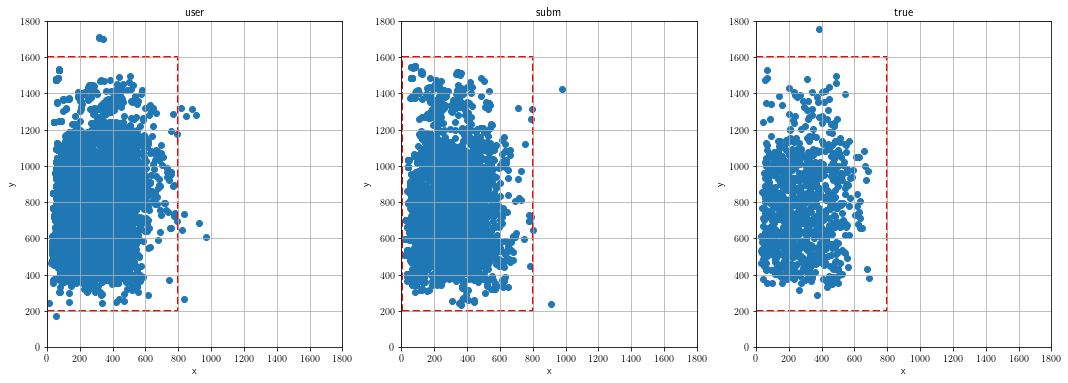

In [6]:
fig = plt.figure(figsize=(18, 6))

ax = fig.add_subplot(1, 3, 1)
ax.grid()
ax.add_patch(plt.Rectangle((1, 200), 799, 1400, fill=False, linewidth=2, linestyle='--', edgecolor='r'))
ax.scatter(user.x_cent, user.y_cent)
ax.set_xlim(0, 1800)
ax.set_ylim(0, 1800)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('user')

ax = fig.add_subplot(1, 3, 2)
ax.grid()
ax.add_patch(plt.Rectangle((1, 200), 799, 1400, fill=False, linewidth=2, linestyle='--', edgecolor='r'))
ax.scatter(subm.x_cent, subm.y_cent)
ax.set_xlim(0, 1800)
ax.set_ylim(0, 1800)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('subm')

ax = fig.add_subplot(1, 3, 3)
ax.grid()
ax.add_patch(plt.Rectangle((1, 200), 799, 1400, fill=False, linewidth=2, linestyle='--', edgecolor='r'))
ax.scatter(true.x_cent, true.y_cent)
ax.set_xlim(0, 1800)
ax.set_ylim(0, 1800)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('true')

plt.show()

Гистограмма центров всех разметок.

In [7]:
x_cent = np.hstack([user.x_cent.values, true.x_cent.values, subm.x_cent.values])
y_cent = np.hstack([user.y_cent.values, true.y_cent.values, subm.y_cent.values])

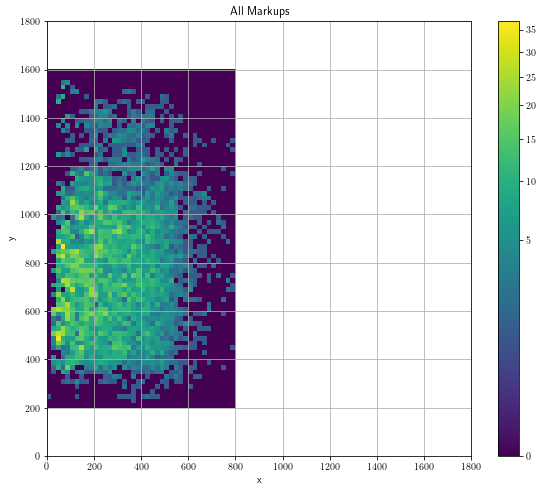

In [8]:
fig = plt.figure(figsize=(9.5, 8))

ax = fig.add_subplot(1, 1, 1)
hist = ax.hist2d(x_cent, y_cent,
                 bins=np.array([40, 70]) * 1,
                 range=[(0, 800), (200, 1600)],
                 norm=mcolors.PowerNorm(0.35))
ax.grid()
ax.set_xlim(0, 1800)
ax.set_ylim(0, 1800)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('All Markups')

plt.colorbar(hist[3], ax=ax)

plt.show()

Теперь взглянем на ошибку в определнии позиции центра. Другими словами смещение пользовательского центра от центра истинной разметки.

In [9]:
joined = pd.merge(user.reset_index().set_index('item_id'), true, left_index=True, right_index=True)
joined['dx'] = joined.x_cent_y - joined.x_cent_x
joined['dy'] = joined.y_cent_y - joined.y_cent_x
joined.head()

,user_id,x_min_x,y_min_x,x_max_x,y_max_x,x_cent_x,y_cent_x,x_min_y,y_min_y,x_max_y,y_max_y,x_cent_y,y_cent_y,dx,dy
item_id,,,,,,,,,,,,,,,
5,141,210,925,483,1255,346.5,1090.0,198,827,649,1340,423.5,1083.5,77.0,-6.5
5,903,151,917,511,1160,331.0,1038.5,198,827,649,1340,423.5,1083.5,92.5,45.0
5,1723,192,914,510,1331,351.0,1122.5,198,827,649,1340,423.5,1083.5,72.5,-39.0
10,903,72,570,420,858,246.0,714.0,26,605,433,847,229.5,726.0,-16.5,12.0
10,1723,96,559,402,856,249.0,707.5,26,605,433,847,229.5,726.0,-19.5,18.5


In [10]:
dxdy = joined[['dx', 'dy']].values
dz = dxdy[:, 0] + 1j * dxdy[:, 1]
theta = np.angle(dz)
radius = np.absolute(dz)

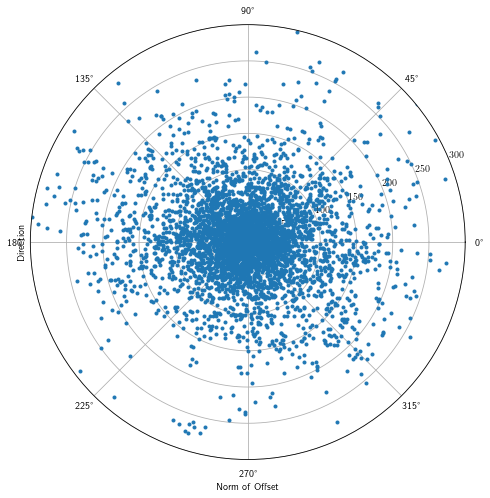

In [11]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1, polar=True)
ax.plot(theta, radius, '.')
ax.set_ylim(0, 300)
ax.set_xlabel('Norm of Offset')
ax.set_ylabel('Direction')
plt.show()

Есть ассиметрия в распределении ошибок между истинным расположением центра и расположением центра пользовательской разметки. В среднем центры смещены влево и вверх. Также есть значительная ассиметрия в угловом распределении.

In [12]:
mean = dxdy.mean(axis=0)
std = dxdy.std(axis=0)

In [13]:
print(f'dx = {mean[0]:6.3f} ± {std[0]:.3f}')
print(f'dy = {mean[1]:6.3f} ± {std[1]:.3f}')

dx = -0.912 ± 74.696
dy =  3.026 ± 59.572


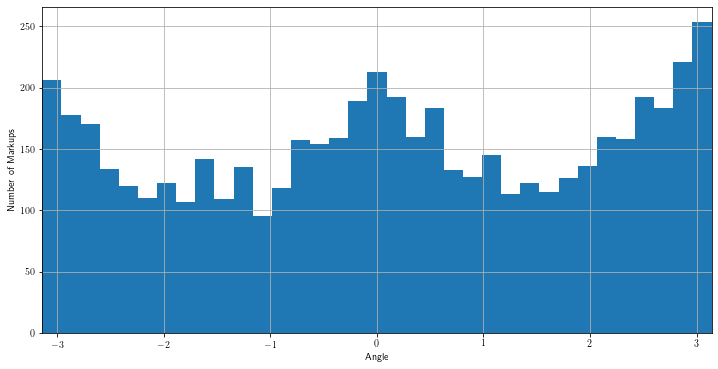

In [14]:
fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(1, 1, 1)
ax.hist(theta, bins=35)
ax.grid()
ax.set_xlim(-np.pi, np.pi)
ax.set_ylim(0)
ax.set_xlabel('Angle')
ax.set_ylabel('Number of Markups')

plt.show()